# Topic Modeling for Patent data

In [ ]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
import nltk
import sys
import re, numpy as np, pandas as pd

In [4]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

In [6]:
# plotly
import plotly.graph_objs as go
import plotly.offline as py
from plotly.graph_objs import *
import plotly.figure_factory as ff

py.init_notebook_mode()

In [7]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [9]:
# for clustering and networking
from scipy.spatial.distance import pdist, squareform
from gensim.matutils import jensen_shannon
import networkx as nx
import itertools as itt

In [10]:
import pickle
#Loading from firm cleaned file
patent_firm = pd.read_pickle('patent_firm_full_clean.pkl')
patent_firm.shape

(43432, 35)

In [ ]:
#patent_csv=pd.read_csv('patent_all_en_new.csv')
#patent_csv.shape

In [11]:
patent = pd.read_pickle('eda.pkl')
patent.shape

(43431, 37)

- appln                     The identifier of the application (with letter at the end, seems Google omits that)
- appln_id                  The (internal) patstat identifier of the application
- family_id                 The (internal) patstat identifier of the family that the application is a member of sets  - sets                      Indicate which sets (fuel-cell = 1, electric  vehicle = 2, both = 3) was matched
- direct                    Indicate whether this application was found directly (title/abstract/cpc/ipc) or      indirectly (family association)
- granted                   Whether or not the application was granted
- earliest_appln            Per family, the earliest application
- earliest_filing_date      The date of the family's earliest application
- publn                     Identifiers of publications associated with this application (*)
- publn_date                The dates of associated publications (*)
- publn_first_grant         Indicates for each publication if its the first one with granted status
- num_cpc_class             The number of CPC classes for this application
- cpc_class                 The CPC class symbols for this application
- num_ipc_class             The number of IPC classes for this application
- ipc_class                 The IPC class symbols for this application
- num_cited_publn           The number of forward citations (this applications refers to other publications)
- cited_publn_date          The dates of cited publications (**)
- cited_publn               The identifiers of cited publications (**)
- cited_appln               The identifiers of the applications  associated with cited publications (**)
- cited_appln_id            The (internal) patstat identifiers of the  applications associated with cited publications (**)
- cited_family_id           The (internal) patstat identifiers of the  family associated with cited publications (**)
- num_cited_family          The total number of distinct families  associated with cited publications (***)
- num_citing_publn          The number of backward citations (other  publications refer to this application)
- citing_publn_date         The dates of citing publications (**)
- citing_publn              The identifiers of citing publications (**)
- citing_appln              The identifiers of the applications  associated with citing publications (**)
- citing_appln_id           The (internal) patstat identifiers of the  applications associated with citing publications (**)
- citing_family_id          The (internal) patstat identifiers of the  family associated with citing publications (**)
- num_citing_family         The total number of distinct families  associated with citing publications (***)
- earliest_applt            The name of the (first) applicant of the  earliest publication of this application 
- current_applt             The name of the (first) applicant of the most recent publication of this application
- appln_title               The title of this application
- assignee                  Cleaning and preprocessed firm titles (^)
- applicate_date            Earliest filing date in date-time format
- year                      Earliest filling date in year.....excluding day and month

>>
>> (*/**) These are one per line, in consistent order


>> (***) These seem to be the numbers that google uses to count citations. You can get this from the export if you aggregate all applications within a family and discard duplicates.

>> (^) This column is taken from previous file i.e File1-Firm_Preprocessing





>> **We have added two new columns i.e application_date and year**

In [12]:
patent.head(2)

appln  appln_id  family_id  sets  direct  granted earliest_appln  \
0   WO9105114W  47158713    1239277     2       1        1    US55592190A   
1  US55592190A  51797454    1239277     2       1        1    US55592190A   

  earliest_filing_date  publn_date        publn  ...   \
0           1990-07-19  1993-02-18  WO9303532A1  ...    
1           1990-07-19  1992-06-09   US5121044A  ...    

                                     citing_appln_id  \
0                                           45621927   
1  52393850\n16916549\n54353461\n48212422\n457802...   

                                    citing_family_id  num_citing_family  \
0                                           24395918                 30   
1  27071024\n1239277\n25508001\n22545199\n2636904...                 30   

                   earliest_applt                   current_applt  \
0   LUZ ELECTRIC FUEL ISRAEL LTD.   LUZ ELECTRIC FUEL ISRAEL LTD.   
1  Luz Electric Fuel Israel, Ltd.  Luz Electric Fuel Israel, Ltd.   

                appln_title  \
0  ELECTRICAL ENERGY SYSTEM   
1  Electrical energy system   

                                         appln_abstr  \
0  An electrical energy system including an elect...   
1  An electrical energy system including an elect...   

                        assignee application_date  year  
0  luz electric fuel israel ltd        1990-07-19  1990  
1  luz electric fuel israel ltd        1990-07-19  1990  

[2 rows x 37 columns]

# 1)- Data Preprocessing and cleaning

In [13]:
patent_abst=patent['appln_abstr']

In [14]:
chars = list(set(patent_abst)) 
data_size, vocab_size = len(patent_abst), len(chars)
print ("Patent data has chars", data_size)
print ("Patent data has unique chars", vocab_size)

Patent data has chars 43431
Patent data has unique chars 37196


### 1.1)-Tokenize Sentences and Clean

In [15]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove extra characters
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [16]:
# Convert to list
data = patent.appln_abstr.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['an', 'electrical', 'energy', 'system', 'including', 'an', 'electric', 'utility', 'having', 'electricity', 'generation', 'apparatus', 'and', 'distribution', 'lines', 'plurality', 'of', 'electric', 'vehicles', 'and', 'electric', 'power', 'storage', 'apparatus', 'receiving', 'electrical', 'power', 'from', 'the', 'electric', 'utility', 'and', 'supplying', 'electrical', 'power', 'to', 'the', 'plurality', 'of', 'electric', 'vehicles', 'and', 'to', 'the', 'electric', 'utility', 'when', 'required', 'discharged', 'slurry', 'is', 'received', 'at', 'discharged', 'slurry', 'storage', 'facility', 'from', 'the', 'electric', 'vehicles', 'and', 'storage', 'battery', 'and', 'supplied', 'to', 'electrolytic', 'cells', 'via', 'suitable', 'pumps', 'the', 'charged', 'slurry', 'is', 'received', 'in', 'facility', 'and', 'then', 'stored', 'in', 'storage', 'battery', 'or', 'supplied', 'to', 'electric', 'vehicles', 'the', 'storage', 'battery', 'provides', 'when', 'necessary', 'or', 'economical', 'electrical',

In [17]:
print(data_words[2])

['piston', 'surface', 'on', 'the', 'combustion', 'chamber', 'side', 'has', 'piston', 'cavity', 'near', 'the', 'pistons', 'axis', 'and', 'recesses', 'for', 'free', 'floating', 'two', 'inlet', 'valves', 'on', 'an', 'inlet', 'side', 'and', 'two', 'outlet', 'valves', 'on', 'an', 'outlet', 'side', 'near', 'to', 'which', 'the', 'piston', 'cavity', 'has', 'platform']


### 1.2)-Build the Bigram, Trigram Models,Postag and Lemmatize
postage : NOUN', 'ADJ', 'VERB', 'ADV

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [20]:
df_data_ready = pd.DataFrame(data_ready)

In [21]:
df_data_ready.head()

0        1           2            3         4           5    \
0  electrical   energy      system      include  electric     utility   
1  electrical   energy      system      include  electric     utility   
2      piston  surface  combustion      chamber      side      piston   
3        idle    phase        fuel   repeatedly    inject       cycle   
4   invention   relate      module  constructed  internal  combustion   

           6           7           8             9    ...    320   321   322  \
0  electricity  generation   apparatus  distribution  ...   None  None  None   
1  electricity    generate   apparatus  distribution  ...   None  None  None   
2       cavity      piston        axis        recess  ...   None  None  None   
3       attain      stable  combustion           way  ...   None  None  None   
4       engine  comprising      engine          case  ...   None  None  None   

    323   324   325   326   327   328   329  
0  None  None  None  None  None  None  None  
1  None  None  None  None  None  None  None  
2  None  None  None  None  None  None  None  
3  None  None  None  None  None  None  None  
4  None  None  None  None  None  None  None  

[5 rows x 330 columns]

In [22]:
df_data_ready.shape

(43431, 330)

In [23]:
import pickle

In [24]:
df_data_ready.to_pickle('data_ready.pkl')
df_data_ready.to_csv('data_ready.csv', index="False")

# 2)-Build the Topic Model

### 2.1)- Create Dictionary

In [25]:
#bag of words
id2word = corpora.Dictionary(data_ready)

In [26]:
print(len(id2word))

18726


In [27]:
count = 0
for k, v in id2word.iteritems():
    print(k, v, id2word.dfs[k])
    count += 1
    if count > 10:
        break

0 activity 86
1 apparatus 3785
2 battery 14140
3 cell 6923
4 charge 13654
5 combination 514
6 conversion 979
7 demand 1404
8 discharge 3622
9 disparate 1
10 distribution 1247


Filter out tokens that appear in
- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 4000 most frequent tokens.

In [28]:
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=4000)

In [29]:
print(len(id2word))

4000


In [30]:
print (id2word[3])

cell


id2word is a dictionary that contains words. All of our data word.

### 2.2)-Create Corpus: Term Document Frequency

Please make clear that document term matrix is not used here

In [31]:
corpus = [id2word.doc2bow(text) for text in data_ready]
corpus[500]

[(18, 1),
 (38, 5),
 (45, 2),
 (46, 2),
 (68, 2),
 (84, 1),
 (93, 3),
 (96, 2),
 (145, 2),
 (162, 1),
 (196, 2),
 (214, 2),
 (257, 1),
 (373, 5),
 (420, 5),
 (460, 1),
 (508, 1),
 (544, 1),
 (614, 1),
 (676, 1),
 (698, 1),
 (761, 1),
 (788, 1),
 (813, 2),
 (872, 1),
 (889, 1),
 (1013, 1),
 (1200, 2),
 (1443, 1),
 (1820, 1)]

In [32]:
print(len(corpus))

43431


In [33]:
bow_doc_500 = corpus[500]

for i in range(len(bow_doc_500)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_500[i][0], 
                                                     id2word[bow_doc_500[i][0]], 
                                                     bow_doc_500[i][1]))

Word 18 ("include") appears 1 time.
Word 38 ("system") appears 5 time.
Word 45 ("chamber") appears 2 time.
Word 46 ("combustion") appears 2 time.
Word 68 ("gas") appears 2 time.
Word 84 ("comprise") appears 1 time.
Word 93 ("engine") appears 3 time.
Word 96 ("internal") appears 2 time.
Word 145 ("curve") appears 2 time.
Word 162 ("point") appears 1 time.
Word 196 ("part") appears 2 time.
Word 214 ("motor") appears 2 time.
Word 257 ("particular") appears 1 time.
Word 373 ("air") appears 5 time.
Word 420 ("duct") appears 5 time.
Word 460 ("small") appears 1 time.
Word 508 ("pub") appears 1 time.
Word 544 ("dispose") appears 1 time.
Word 614 ("compartment") appears 1 time.
Word 676 ("lead") appears 1 time.
Word 698 ("pass") appears 1 time.
Word 761 ("intend") appears 1 time.
Word 788 ("component") appears 1 time.
Word 813 ("various") appears 2 time.
Word 872 ("space") appears 1 time.
Word 889 ("course") appears 1 time.
Word 1013 ("region") appears 1 time.
Word 1200 ("guide") appears 2 tim

### Use TF-IDF 

other alternative of vectorization is using TF-IDF

In [34]:
from gensim import corpora, models

tfidf = models.TfidfModel(corpus)

In [35]:
corpus_tfidf = tfidf[corpus]

In [36]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.14110495895435243),
 (1, 0.11063044326140917),
 (2, 0.07631508812725724),
 (3, 0.041627611857402325),
 (4, 0.02623121375262935),
 (5, 0.1005756210236055),
 (6, 0.0859698025015532),
 (7, 0.15559304610880517),
 (8, 0.11262619949217896),
 (9, 0.0804847167470286),
 (10, 0.26489377610571563),
 (11, 0.2714817540659639),
 (12, 0.0697530817464587),
 (13, 0.13088288951410246),
 (14, 0.08685201070063335),
 (15, 0.2143709210959421),
 (16, 0.0645366707019696),
 (17, 0.04284507638202463),
 (18, 0.02151065041233554),
 (19, 0.08875600044879099),
 (20, 0.09525409667697544),
 (21, 0.039180985317152854),
 (22, 0.11113634514892923),
 (23, 0.08769981121476386),
 (24, 0.17100202289740687),
 (25, 0.09129610255791754),
 (26, 0.03439935356332801),
 (27, 0.07626699551634038),
 (28, 0.15626533753009522),
 (29, 0.06227002195255668),
 (30, 0.12289840529391044),
 (31, 0.5335632725763517),
 (32, 0.15629675459988193),
 (33, 0.3405429046548888),
 (34, 0.060751107736457775),
 (35, 0.09117925184834832),
 (36, 0.

### 2.3)-Build LDA model

In [37]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes=2, workers=2)

In [38]:
lda_model.save('topic_model_bow')

In [39]:
from gensim.models import LdaModel
lda_model = LdaModel.load('topic_model_bow')

In [40]:
#The trained topics (keywords and weights)
pprint(lda_model.print_topics())

[(0,
  '0.033*"first" + 0.028*"second" + 0.025*"gear" + 0.024*"shaft" + '
  '0.023*"motor" + 0.023*"connect" + 0.016*"drive" + 0.016*"side" + '
  '0.013*"mechanism" + 0.013*"include"'),
 (1,
  '0.086*"charge" + 0.047*"battery" + 0.027*"module" + 0.015*"automobile" + '
  '0.015*"connect" + 0.013*"provide" + 0.013*"model" + 0.012*"utility" + '
  '0.011*"include" + 0.011*"device"'),
 (2,
  '0.131*"power" + 0.031*"system" + 0.030*"supply" + 0.029*"energy" + '
  '0.028*"device" + 0.025*"unit" + 0.024*"charge" + 0.024*"storage" + '
  '0.013*"electrical" + 0.011*"include"'),
 (3,
  '0.040*"battery" + 0.038*"voltage" + 0.036*"current" + 0.030*"value" + '
  '0.025*"charge" + 0.015*"circuit" + 0.014*"motor" + 0.013*"high" + '
  '0.012*"method" + 0.010*"unit"'),
 (4,
  '0.040*"battery" + 0.039*"power" + 0.029*"voltage" + 0.028*"charge" + '
  '0.023*"signal" + 0.022*"switch" + 0.022*"output" + 0.021*"device" + '
  '0.018*"circuit" + 0.017*"first"'),
 (5,
  '0.050*"engine" + 0.040*"drive" + 0.031*"

### b)- LDA with TF-IDF

In [41]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus=corpus_tfidf, num_topics=10, id2word=id2word, passes=2, workers=2)

"""
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
                                           
                                    """

"\nlda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,\n                                           id2word=id2word,\n                                           num_topics=10, \n                                           random_state=100,\n                                           update_every=1,\n                                           chunksize=10,\n                                           passes=10,\n                                           alpha='symmetric',\n                                           iterations=100,\n                                           per_word_topics=True)\n                                           \n                                    "

In [42]:
lda_model_tfidf.save('topic_model_tfidf')

In [43]:
from gensim.models import LdaModel
lda_model_tfidf = LdaModel.load('topic_model_tfidf')

In [44]:
#The trained topics (keywords and weights)
pprint(lda_model_tfidf.print_topics())

[(0,
  '0.025*"gear" + 0.022*"shaft" + 0.015*"transmission" + 0.013*"first" + '
  '0.013*"motor" + 0.012*"second" + 0.012*"drive" + 0.012*"clutch" + '
  '0.011*"wheel" + 0.011*"mechanism"'),
 (1,
  '0.026*"brake" + 0.021*"regenerative" + 0.019*"torque" + 0.011*"engine" + '
  '0.011*"driveline" + 0.010*"motor" + 0.009*"hybrid" + 0.008*"speed" + '
  '0.008*"generator" + 0.007*"method"'),
 (2,
  '0.019*"torque" + 0.018*"engine" + 0.015*"speed" + 0.015*"clutch" + '
  '0.014*"mode" + 0.013*"motor" + 0.012*"start" + 0.011*"drive" + '
  '0.010*"hybrid" + 0.009*"travel"'),
 (3,
  '0.007*"engine" + 0.007*"energy" + 0.007*"machine" + 0.007*"chip" + '
  '0.007*"method" + 0.006*"electrical" + 0.006*"battery" + 0.006*"value" + '
  '0.006*"system" + 0.006*"charge"'),
 (4,
  '0.023*"charge" + 0.014*"energy" + 0.012*"station" + 0.012*"system" + '
  '0.011*"information" + 0.011*"power" + 0.010*"battery" + 0.010*"storage" + '
  '0.009*"module" + 0.008*"electrical"'),
 (5,
  '0.011*"charge" + 0.010*"body

# 3) Evaluating model

### 3.1)- Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

In [45]:
# Compute Perplexity:a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 


Perplexity:  -6.08487698813623


In [46]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5075837604096765


In [47]:
#For TF-IDF
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf)) 
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.928031544073132

Coherence Score:  0.5766592453529228


**We can see that coherence score for TF-IDF is higher than bag of word model.**

### 3.2)- to find the optimal number of topics for LDA

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [52]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)

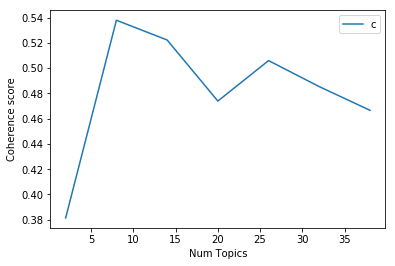

In [53]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [54]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3814
Num Topics = 8  has Coherence Value of 0.5379
Num Topics = 14  has Coherence Value of 0.5223
Num Topics = 20  has Coherence Value of 0.4739
Num Topics = 26  has Coherence Value of 0.506
Num Topics = 32  has Coherence Value of 0.4853
Num Topics = 38  has Coherence Value of 0.4666


**As highest value is with topic 8. So , it is best optimal size**

In [55]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.045*"engine" + 0.033*"torque" + 0.028*"motor" + 0.026*"hybrid" + '
  '0.025*"mode" + 0.023*"speed" + 0.022*"value" + 0.021*"drive" + '
  '0.016*"start" + 0.016*"power"'),
 (1,
  '0.062*"engine" + 0.054*"combustion" + 0.045*"internal" + 0.032*"pressure" + '
  '0.029*"valve" + 0.023*"cylinder" + 0.022*"fuel" + 0.022*"air" + '
  '0.018*"exhaust" + 0.014*"method"'),
 (2,
  '0.054*"motor" + 0.045*"first" + 0.043*"drive" + 0.040*"second" + '
  '0.032*"gear" + 0.026*"transmission" + 0.026*"clutch" + 0.025*"shaft" + '
  '0.021*"engine" + 0.018*"connect"'),
 (3,
  '0.065*"battery" + 0.041*"temperature" + 0.037*"charge" + 0.023*"system" + '
  '0.019*"information" + 0.017*"cool" + 0.014*"time" + 0.013*"brake" + '
  '0.013*"configure" + 0.013*"method"'),
 (4,
  '0.026*"body" + 0.022*"side" + 0.018*"provide" + 0.017*"model" + '
  '0.017*"part" + 0.014*"fix" + 0.014*"support" + 0.013*"end" + 0.013*"case" + '
  '0.013*"include"'),
 (5,
  '0.118*"charge" + 0.054*"battery" + 0.040*"module" + 

# 4)- Repeat same procedure for TF-IDF model as well

In [56]:
# Compute Perplexity:a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf)) 


Perplexity:  -7.928161643486282


In [57]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5766592453529228


In [58]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [59]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=data_ready, start=2, limit=40, step=6)

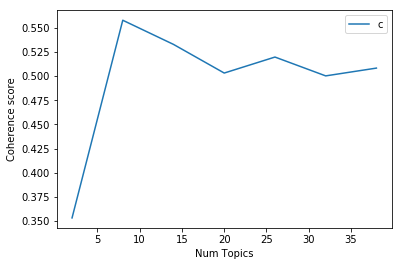

In [60]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3533
Num Topics = 8  has Coherence Value of 0.5577
Num Topics = 14  has Coherence Value of 0.5327
Num Topics = 20  has Coherence Value of 0.5031
Num Topics = 26  has Coherence Value of 0.5196
Num Topics = 32  has Coherence Value of 0.5002
Num Topics = 38  has Coherence Value of 0.5082


**As highest value is with topic 8. So , it is best optimal size**

In [62]:
# Select the model and print the topics. We choose 6 so, list[1].
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"layer" + 0.018*"electrode" + 0.015*"catalyst" + 0.013*"interaction" '
  '+ 0.012*"man" + 0.012*"ion" + 0.012*"carbon" + 0.011*"material" + '
  '0.011*"evaluation" + 0.011*"message"'),
 (1,
  '0.023*"cell" + 0.023*"cool" + 0.017*"fuel" + 0.017*"air" + 0.016*"stack" + '
  '0.014*"heat" + 0.014*"water" + 0.013*"fill" + 0.012*"temperature" + '
  '0.011*"coolant"'),
 (2,
  '0.018*"charge" + 0.015*"pile" + 0.013*"automobile" + 0.013*"utility" + '
  '0.011*"model" + 0.010*"body" + 0.009*"module" + 0.008*"battery" + '
  '0.007*"box" + 0.007*"connect"'),
 (3,
  '0.015*"powertrain" + 0.014*"photovoltaic" + 0.013*"signal" + 0.012*"pure" + '
  '0.010*"event" + 0.010*"gradient" + 0.010*"vibration" + 0.008*"downhill" + '
  '0.008*"slope" + 0.008*"cl"'),
 (4,
  '0.017*"engine" + 0.017*"torque" + 0.014*"clutch" + 0.013*"mode" + '
  '0.013*"speed" + 0.013*"motor" + 0.012*"gear" + 0.012*"drive" + '
  '0.011*"hybrid" + 0.010*"transmission"'),
 (5,
  '0.025*"voltage" + 0.020*"battery" + 0.0

### Label Topic

- Topic 1
- Topic 2
- Topic 3
- Topic 4
- Topic 5
- Topic 6
- Topic 7
- Topic 8

### Save work with models and other

In [109]:
optimal_model.save('optimal_topic_model')

In [111]:
corpus_tfidf.save('corpus_tfidf')

In [112]:
id2word.save('id2word')

In [64]:
from gensim.models import LdaModel
optimal_model  = LdaModel.load('optimal_topic_model')

In [65]:
# use show_topic()
optimal_model.show_topics(num_topics=6)

[(5,
  '0.025*"voltage" + 0.020*"battery" + 0.016*"circuit" + 0.014*"power" + 0.014*"module" + 0.012*"dc" + 0.012*"charge" + 0.011*"converter" + 0.011*"current" + 0.010*"cell"'),
 (3,
  '0.015*"powertrain" + 0.014*"photovoltaic" + 0.013*"signal" + 0.012*"pure" + 0.010*"event" + 0.010*"gradient" + 0.010*"vibration" + 0.008*"downhill" + 0.008*"slope" + 0.008*"cl"'),
 (4,
  '0.017*"engine" + 0.017*"torque" + 0.014*"clutch" + 0.013*"mode" + 0.013*"speed" + 0.013*"motor" + 0.012*"gear" + 0.012*"drive" + 0.011*"hybrid" + 0.010*"transmission"'),
 (2,
  '0.018*"charge" + 0.015*"pile" + 0.013*"automobile" + 0.013*"utility" + 0.011*"model" + 0.010*"body" + 0.009*"module" + 0.008*"battery" + 0.007*"box" + 0.007*"connect"'),
 (1,
  '0.023*"cell" + 0.023*"cool" + 0.017*"fuel" + 0.017*"air" + 0.016*"stack" + 0.014*"heat" + 0.014*"water" + 0.013*"fill" + 0.012*"temperature" + 0.011*"coolant"'),
 (0,
  '0.019*"layer" + 0.018*"electrode" + 0.015*"catalyst" + 0.013*"interaction" + 0.012*"man" + 0.012*"i

# 5)- Analysis of LDA model

The function get_term_topics returns the odds of a particular word belonging to some particular topic

In [66]:
optimal_model.get_term_topics('battery')

[(5, 0.01994871), (7, 0.0104516335)]

The get_document_topics method returns topic distribution of the document along with topic distribution for each word in that document

In [67]:
print(data_ready[0])

['electrical', 'energy', 'system', 'include', 'electric', 'utility', 'electricity', 'generation', 'apparatus', 'distribution', 'plurality', 'electric', 'vehicle', 'electric', 'power', 'storage', 'apparatus', 'receive', 'electrical', 'power', 'electric', 'utility', 'supply', 'electrical', 'power', 'plurality', 'electric', 'vehicle', 'electric', 'utility', 'require', 'discharge', 'slurry', 'receive', 'discharge', 'slurry', 'storage', 'facility', 'electric', 'vehicle', 'storage', 'battery', 'supply', 'electrolytic', 'cell', 'suitable', 'pump', 'charge', 'slurry', 'receive', 'facility', 'store', 'storage', 'battery', 'supply', 'electric', 'vehicle', 'storage', 'battery', 'provide', 'necessary', 'economical', 'electrical', 'power', 'transmission', 'conversion', 'unit', 'synergistic', 'combination', 'disparate', 'activity', 'utility', 'energy', 'storage', 'electric', 'vehicle', 'operation', 'presently', 'uneconomical', 'provide', 'economical', 'electrical', 'utility', 'low', 'demand', 'stora

In [68]:
doc_number = 0
doc_topic, word_topic, phi_value = optimal_model.get_document_topics(corpus_tfidf[doc_number], per_word_topics=True)

In [69]:
doc_topic

[(0, 0.020696541),
 (1, 0.2295569),
 (2, 0.020719513),
 (3, 0.046527687),
 (4, 0.020719247),
 (5, 0.38555646),
 (6, 0.044767346),
 (7, 0.23145631)]

The output gives the topic distribution of the document

In [70]:
word_topic

[(0, [1]),
 (1, [5, 7, 1]),
 (2, [5, 7]),
 (3, [1, 5]),
 (4, [7, 5]),
 (5, [5, 7]),
 (6, [5]),
 (7, [7, 5]),
 (8, [5, 7, 1]),
 (9, [5, 7]),
 (10, [1, 7]),
 (11, [5, 7, 1]),
 (12, [5, 7]),
 (13, [5, 1]),
 (14, [5, 7]),
 (15, [7, 5, 1]),
 (16, [5]),
 (17, [5]),
 (18, [5]),
 (19, [5, 1]),
 (20, [7, 1, 5]),
 (21, [5, 7]),
 (22, [5, 7, 1]),
 (23, [5, 7]),
 (24, [7]),
 (25, [5]),
 (26, [5]),
 (27, [1]),
 (28, [7, 5]),
 (29, [7, 5]),
 (30, [5, 1]),
 (31, [1]),
 (32, [3]),
 (33, [5, 7, 1]),
 (34, [5, 7, 1]),
 (35, [5, 7]),
 (36, [5, 7, 1]),
 (37, [6]),
 (38, [5, 7]),
 (39, [7, 5]),
 (40, [5, 7]),
 (41, [5, 1])]

Output gives you word belonging to topics in given documents. In our case, its 1st row

In [71]:
phi_value

[(0, [(1, 0.14025193)]),
 (1, [(1, 0.01124562), (5, 0.06194109), (7, 0.036575597)]),
 (2, [(5, 0.055628795), (7, 0.014782701)]),
 (3, [(1, 0.021250889), (5, 0.019346215)]),
 (4, [(5, 0.011542204), (7, 0.014598092)]),
 (5, [(5, 0.06275981), (7, 0.033400394)]),
 (6, [(5, 0.08036943)]),
 (7, [(5, 0.057224303), (7, 0.09687521)]),
 (8, [(1, 0.0149232745), (5, 0.07238938), (7, 0.025168555)]),
 (9, [(5, 0.05497582), (7, 0.023181414)]),
 (10, [(1, 0.14061548), (7, 0.12387359)]),
 (11, [(1, 0.010534587), (5, 0.20016213), (7, 0.060353216)]),
 (12, [(5, 0.043564554), (7, 0.023025649)]),
 (13, [(1, 0.02333849), (5, 0.10746738)]),
 (14, [(5, 0.059582867), (7, 0.025362805)]),
 (15, [(1, 0.025023121), (5, 0.033324126), (7, 0.15598843)]),
 (16, [(5, 0.046944767)]),
 (17, [(5, 0.037466142)]),
 (18, [(5, 0.010954033)]),
 (19, [(1, 0.018135166), (5, 0.06525709)]),
 (20, [(1, 0.034917053), (5, 0.018041955), (7, 0.041093707)]),
 (21, [(5, 0.021433447), (7, 0.013838924)]),
 (22, [(1, 0.017171532), (5, 0.062

The output gives a ranked list of topics for every word. The lower the rank, more is the probability of the word belonging to that topic in the document.<br>
Phi values are essentially the probability of that word in that document belonging to a particular topic

### 5.1)-the Dominant topic and its percentage contribution in each document

In [72]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_tfidf, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             5.0              0.3857   
1            1             5.0              0.7969   
2            2             2.0              0.4514   
3            3             6.0              0.7163   
4            4             4.0              0.5670   
5            5             4.0              0.5652   
6            6             4.0              0.4909   
7            7             5.0              0.4658   
8            8             6.0              0.4455   
9            9             5.0              0.8473   

                                            Keywords  \
0  voltage, battery, circuit, power, module, dc, ...   
1  voltage, battery, circuit, power, module, dc, ...   
2  charge, pile, automobile, utility, model, body...   
3  valve, combustion, fuel, oil, cylinder, pressu...   
4  engine, torque, clutch, mode, speed, motor, ge...   
5  engine, torque, clutch, mode, speed, motor, ge...   
6  engine, torque, clutch, mode, speed, motor, ge...   
7  voltage, battery, circuit, power, module, dc, ...   
8  valve, combustion, fuel, oil, cylinder, pressu...   
9  voltage, battery, circuit, power, module, dc, ...   

                                                Text  
0  [electrical, energy, system, include, electric...  
1  [electrical, energy, system, include, electric...  
2  [piston, surface, combustion, chamber, side, p...  
3  [idle, phase, fuel, repeatedly, inject, cycle,...  
4  [invention, relate, module, constructed, inter...  
5  [invention, relate, module, constructed, inter...  
6  [invention, relate, modular, internal, combust...  
7  [charge, battery, involve, external, current, ...  
8  [cylinder, block, crankcase, generally, cast, ...  
9  [regulate, circuit, microprocessor, regulator,...

In [73]:
df_dominant_topic.head(15)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0             0             5.0              0.3857   
1             1             5.0              0.7969   
2             2             2.0              0.4514   
3             3             6.0              0.7163   
4             4             4.0              0.5670   
5             5             4.0              0.5652   
6             6             4.0              0.4909   
7             7             5.0              0.4658   
8             8             6.0              0.4455   
9             9             5.0              0.8473   
10           10             2.0              0.4512   
11           11             1.0              0.7929   
12           12             5.0              0.7235   
13           13             5.0              0.8315   
14           14             4.0              0.6535   

                                             Keywords  \
0   voltage, battery, circuit, power, module, dc, ...   
1   voltage, battery, circuit, power, module, dc, ...   
2   charge, pile, automobile, utility, model, body...   
3   valve, combustion, fuel, oil, cylinder, pressu...   
4   engine, torque, clutch, mode, speed, motor, ge...   
5   engine, torque, clutch, mode, speed, motor, ge...   
6   engine, torque, clutch, mode, speed, motor, ge...   
7   voltage, battery, circuit, power, module, dc, ...   
8   valve, combustion, fuel, oil, cylinder, pressu...   
9   voltage, battery, circuit, power, module, dc, ...   
10  charge, pile, automobile, utility, model, body...   
11  cell, cool, fuel, air, stack, heat, water, fil...   
12  voltage, battery, circuit, power, module, dc, ...   
13  voltage, battery, circuit, power, module, dc, ...   
14  engine, torque, clutch, mode, speed, motor, ge...   

                                                 Text  
0   [electrical, energy, system, include, electric...  
1   [electrical, energy, system, include, electric...  
2   [piston, surface, combustion, chamber, side, p...  
3   [idle, phase, fuel, repeatedly, inject, cycle,...  
4   [invention, relate, module, constructed, inter...  
5   [invention, relate, module, constructed, inter...  
6   [invention, relate, modular, internal, combust...  
7   [charge, battery, involve, external, current, ...  
8   [cylinder, block, crankcase, generally, cast, ...  
9   [regulate, circuit, microprocessor, regulator,...  
10  [drive, unit, electric, vehicle, comprise, ele...  
11  [drive, unit, electric, motor, car, comprise, ...  
12  [control, circuit, controller, provide, microp...  
13  [system, board, charge, battery, electrical, v...  
14  [invention, drive, electric, vehicle, drive, s...

In [74]:
df_dominant_topic.shape

(43431, 5)

In [75]:
df_dominant_topic.Dominant_Topic.value_counts()

4.0    15371
5.0     7647
2.0     6455
7.0     5195
6.0     4022
1.0     3303
0.0      925
3.0      513
Name: Dominant_Topic, dtype: int64

In [107]:
import pickle
df_dominant_topic.to_pickle('top08_topic_dominant.pkl')
df_dominant_topic.to_csv('top08_topic_dominant.csv', index="False")

In [77]:
print(df_dominant_topic['Text'][2])

['piston', 'surface', 'combustion', 'chamber', 'side', 'piston', 'cavity', 'piston', 'axis', 'recess', 'free', 'float', 'inlet', 'valve', 'inlet', 'side', 'outlet', 'valve', 'outlet', 'side', 'piston', 'cavity', 'platform']


In [78]:
print(patent['appln_abstr'][2])

A piston surface (4) on the combustion chamber side has a piston cavity (12) near the piston's axis and recesses (22,24) for free floating two inlet valves on an inlet side (21) and two outlet valves on an outlet side (23), near to which the piston cavity has a platform (5).


**Compare with original text i.e uncleaned**

### 5.2)-Topic distribution across documents

In [79]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 8)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

Dominant_Topic                                     Topic_Keywords  \
0             5.0  voltage, battery, circuit, power, module, dc, ...   
1             5.0  voltage, battery, circuit, power, module, dc, ...   
2             2.0  charge, pile, automobile, utility, model, body...   
3             6.0  valve, combustion, fuel, oil, cylinder, pressu...   
4             4.0  engine, torque, clutch, mode, speed, motor, ge...   

   Num_Documents  Perc_Documents  
0          925.0        0.021298  
1         3303.0        0.076052  
2         6455.0        0.148627  
3          513.0        0.011812  
4        15371.0        0.353918

In [80]:
df_dominant_topics.head(8)

Dominant_Topic                                     Topic_Keywords  \
0             5.0  voltage, battery, circuit, power, module, dc, ...   
1             5.0  voltage, battery, circuit, power, module, dc, ...   
2             2.0  charge, pile, automobile, utility, model, body...   
3             6.0  valve, combustion, fuel, oil, cylinder, pressu...   
4             4.0  engine, torque, clutch, mode, speed, motor, ge...   
5             4.0  engine, torque, clutch, mode, speed, motor, ge...   
6             4.0  engine, torque, clutch, mode, speed, motor, ge...   
7             5.0  voltage, battery, circuit, power, module, dc, ...   

   Num_Documents  Perc_Documents  
0          925.0        0.021298  
1         3303.0        0.076052  
2         6455.0        0.148627  
3          513.0        0.011812  
4        15371.0        0.353918  
5         7647.0        0.176072  
6         4022.0        0.092607  
7         5195.0        0.119615

### 5.2)-The most representative sentence for each topic

In [81]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.8414   
1        1.0              0.8727   
2        2.0              0.8732   
3        3.0              0.8194   
4        4.0              0.8870   
5        5.0              0.8773   
6        6.0              0.8744   
7        7.0              0.8703   

                                                                                     Keywords  \
0    layer, electrode, catalyst, interaction, man, ion, carbon, material, evaluation, message   
1                       cell, cool, fuel, air, stack, heat, water, fill, temperature, coolant   
2               charge, pile, automobile, utility, model, body, module, battery, box, connect   
3     powertrain, photovoltaic, signal, pure, event, gradient, vibration, downhill, slope, cl   
4               engine, torque, clutch, mode, speed, motor, gear, drive, hybrid, transmission   
5              voltage, battery, circuit, power, module, dc, charge, converter, current, cell   
6            valve, combustion, fuel, oil, cylinder, pressure, gas, exhaust, engine, internal   
7  charge, information, wireless, module, communication, battery, unit, datum, station, power   

                                                                                   Representative Text  
0  [invention, relate, method, produce, melt, carbonate, fuel, cell, comprising, cathode, layer, po...  
1  [system, regulate, operating, environment, electric, vehicle, battery, divide, battery, section,...  
2  [utility, model, relate, technical_field, electric, vehicle, charge, disclose, electric, vehicle...  
3  [resistance, calculation, activator, determine, electric, car, stop, basis, drive, command, sign...  
4  [problem, solve, obtain, large, driving, force, small, first, electric, motor, time, start, prev...  
5  [purpose, provide, battery, capable, deal, output, demand, wide, range, low, load, high, load, c...  
6  [open, close, frequency, intake, control, valve, control, intake, amount, open, close, time, pro...  
7  [purpose, provide, hybrid, vehicle, residual, amount, battery, efficiency, arrival, destination,...

In [82]:
print(sent_topics_sorteddf_mallet['Representative Text'][0])

['invention', 'relate', 'method', 'produce', 'melt', 'carbonate', 'fuel', 'cell', 'comprising', 'cathode', 'layer', 'porous', 'nickel', 'oxide', 'anode', 'layer', 'porous', 'nickel', 'melt', 'arrange', 'cathode', 'layer', 'anode', 'layer', 'receive', 'form', 'finely', 'porous', 'electrolyte', 'matrix', 'melt', 'consist', 'alkali_metal', 'carbonate', 'electrolyte', 'order', 'produce', 'cathode', 'layer', 'sinter', 'coated', 'electrode', 'path', 'coat', 'catalytically', 'activate', 'particle', 'porous', 'nickel', 'fuel', 'cell', 'operation', 'mode', 'react', 'form', 'nickel', 'oxide', 'accord', 'invention', 'electrode', 'path', 'coat', 'catalytic', 'activating', 'particle', 'oxidic', 'inorganic', 'metal', 'compound', 'react', 'form', 'correspond', 'metal', 'oxide', 'gas', 'development', 'invention', 'relate', 'similar', 'fuel', 'cell', 'increase', 'activation', 'cathode', 'reaction']


**For our topic model analysis, stop here. We can do this for semantic analysis part.**

# 6)- Visualize

In [83]:
import nltk; nltk.download('stopwords')
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\69785hsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

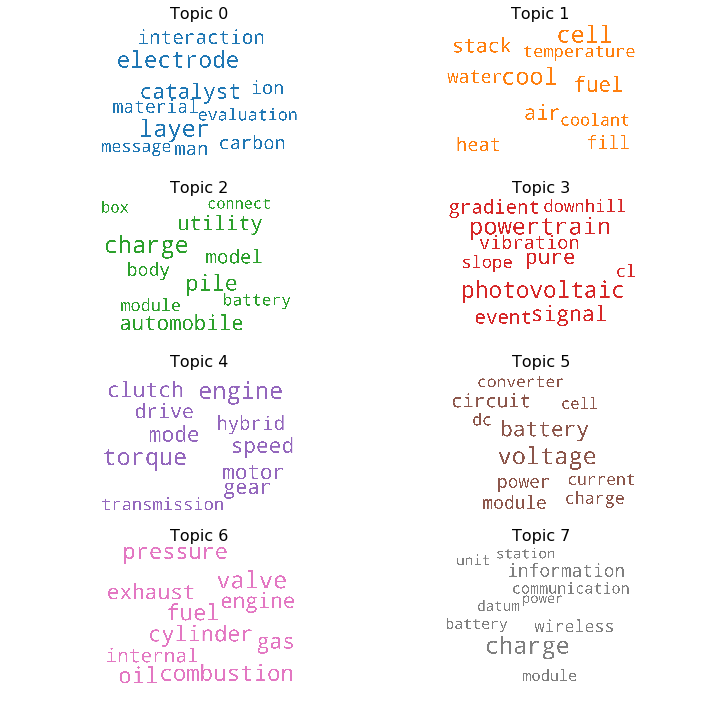

In [86]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True) # watch this value

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1]) # for 8 topics
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 6.1)- Bar-plot

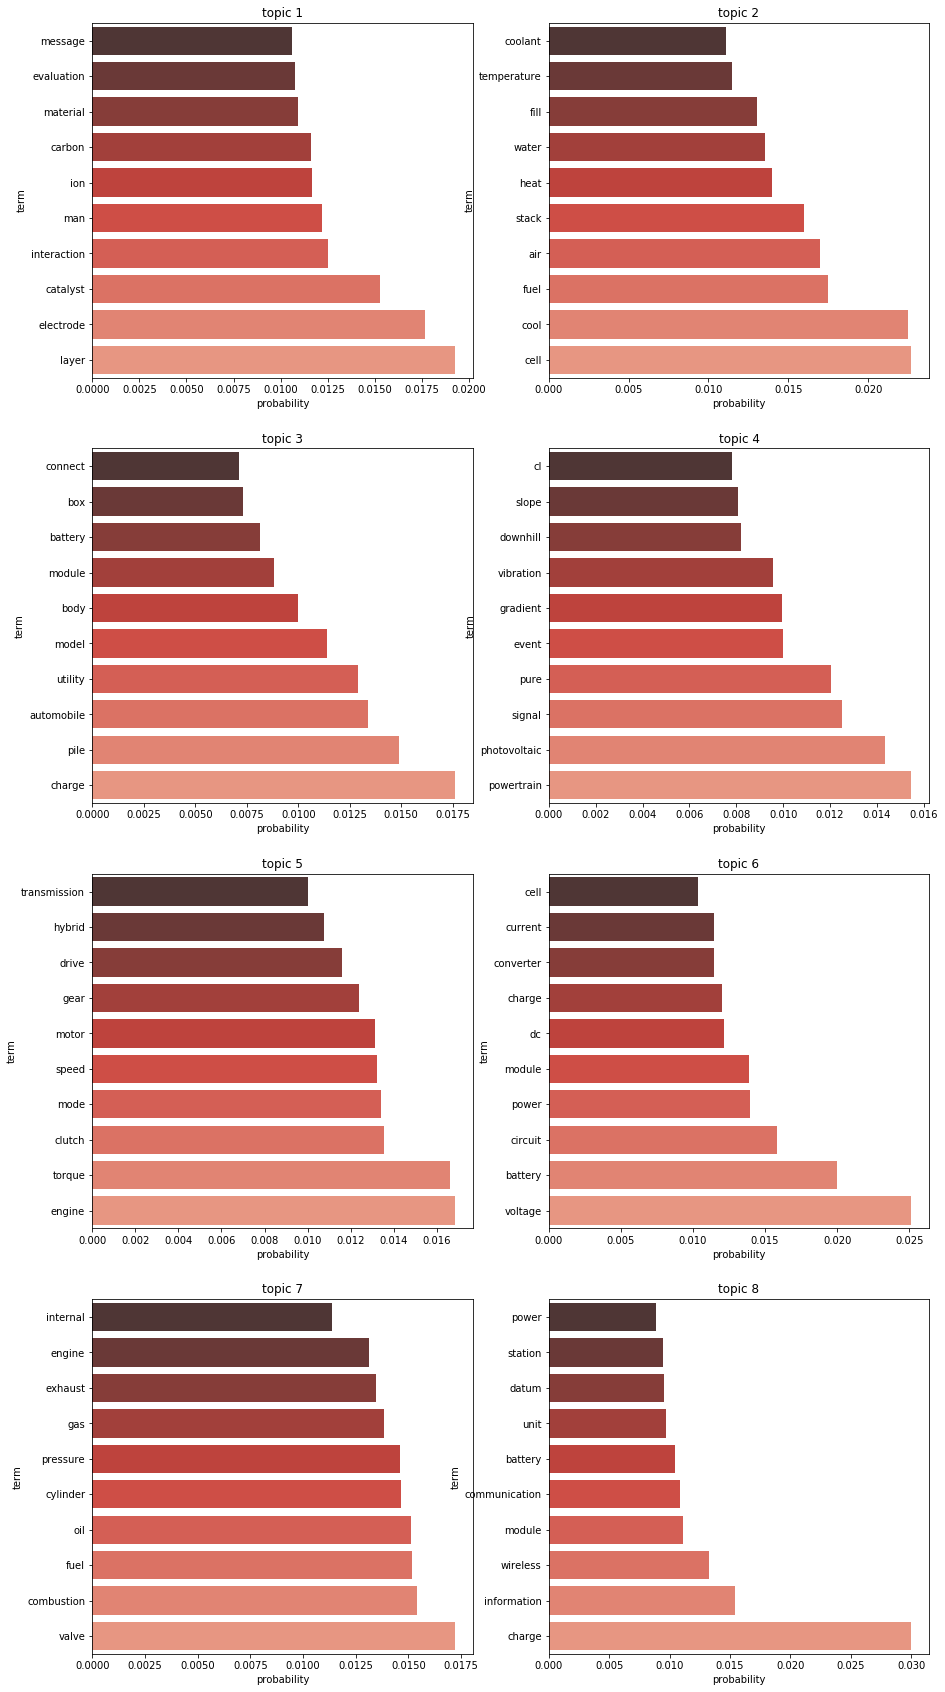

In [87]:
fiz=plt.figure(figsize=(15,30))
for i in range(8):
    df=pd.DataFrame(optimal_model.show_topic(i), columns=['term','prob']).set_index('term')
    df=df.sort_values('prob')
    
    plt.subplot(4,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='patents', palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

In [88]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, dictionary=optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.086919 -0.117368       1        1  29.069180
5      0.092989  0.039456       2        1  15.843494
2      0.111148  0.202458       3        1  14.395235
7      0.148367 -0.020814       4        1  11.831330
6     -0.100871 -0.043824       5        1  10.214782
1     -0.098038  0.192180       6        1   9.290496
0     -0.289330 -0.040942       7        1   4.682279
3      0.048816 -0.211147       8        1   4.673201, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
4     Default  1736.000000          charge  1736.000000  30.0000  30.0000
172   Default   971.000000         voltage   971.000000  29.0000  29.0000
577   Default  1030.000000          torque  1030.000000  28.0000  28.0000
3     Default   879.000000            cell   879.000000  27.0000  27.0000
228   Default   471.000000            cool   471.000000  26.0000  26.0000
93    Default  1289.000000          engine  1289.000000  25.0000  25.0000
83    Default   790.000000          clutch   790.000000  24.0000  24.0000
67    Default  1014.000000            fuel  1014.000000  23.0000  23.0000
373   Default   589.000000             air   589.000000  22.0000  22.0000
1853  Default   438.000000            pile   438.000000  21.0000  21.0000
56    Default   412.000000           valve   412.000000  20.0000  20.0000
46    Default   571.000000      combustion   571.000000  19.0000  19.0000
124   Default   737.000000            gear   737.000000  18.0000  18.0000
193   Default   369.000000             oil   369.000000  17.0000  17.0000
898   Default   462.000000     information   462.000000  16.0000  16.0000
101   Default  1000.000000          module  1000.000000  15.0000  15.0000
1862  Default   311.000000        wireless   311.000000  14.0000  14.0000
552   Default   364.000000           stack   364.000000  13.0000  13.0000
584   Default   402.000000              dc   402.000000  12.0000  12.0000
1473  Default   294.000000        catalyst   294.000000  11.0000  11.0000
41    Default   493.000000         utility   493.000000  10.0000  10.0000
1621  Default   266.000000       electrode   266.000000   9.0000   9.0000
89    Default   326.000000        cylinder   326.000000   8.0000   8.0000
2     Default  1409.000000         battery  1409.000000   7.0000   7.0000
111   Default   848.000000           speed   848.000000   6.0000   6.0000
206   Default   683.000000         circuit   683.000000   5.0000   5.0000
246   Default   455.000000           brake   455.000000   4.0000   4.0000
985   Default   212.000000           layer   212.000000   3.0000   3.0000
68    Default   427.000000             gas   427.000000   2.0000   2.0000
360   Default   337.000000         exhaust   337.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
712    Topic8    30.213602  transformation    32.254406   2.9980  -5.7273
2122   Topic8    74.783905           slope    83.403679   2.9542  -4.8209
2501   Topic8    23.869644            tire    25.259335   3.0067  -5.9629
738    Topic8   111.846474            pure   134.569946   2.8784  -4.4184
1042   Topic8    34.959389         annular    38.241070   2.9736  -5.5814
2181   Topic8    53.200199            slow    61.043087   2.9258  -5.1615
1151   Topic8    49.652214      indicative    57.536671   2.9159  -5.2305
875    Topic8    48.984280       amplitude    56.748219   2.9162  -5.2440
1449   Topic8    92.609390           event   118.170578   2.8196  -4.6072
878    Topic8    55.983238            damp    66.702057   2.8881  -5.1105
1988   Topic8    58.956909            last    75.881363   2.8110  -5.0587
1471   Topic8    50.119946             sum    62.606480   2.8409  -5.2211
2663   Topic8    36.800854     disturbance    42.080105   2.9293  -5.5300
2787   Topic8

In [89]:
pyLDAvis.save_html(vis, 'pyLDAvis.html')

### 6.2) Heatmap

In [90]:
def plot_difference(mdiff, title="", annotation=None):
    """
    Helper function to plot difference between models
    """
    annotation_html = None
    if annotation is not None:
        annotation_html = [["+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                            for (int_tokens, diff_tokens) in row]
                           for row in annotation]
        
    data = Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = Layout(width=950, height=950, title=title,
                       xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

In [91]:
difference_matrix, annotation = optimal_model.diff(optimal_model, distance='jensen_shannon', num_words=50)
plot_difference(difference_matrix, title="Topic difference [jensen shannon distance]", annotation=annotation)

### Topic network

In [92]:
# get topic distributions
topic_dist = optimal_model.state.get_lambda()

# get topic terms
num_words = 50
topic_terms = [{w for (w, _) in optimal_model.show_topic(topic, topn=num_words)} for topic in range(topic_dist.shape[0])]

In [93]:
from scipy.spatial.distance import pdist, squareform
from gensim.matutils import jensen_shannon
import networkx as nx
import itertools as itt

# calculate distance matrix using the input distance metric
def distance(X, dist_metric):
    return squareform(pdist(X, lambda u, v: dist_metric(u, v)))

topic_distance = distance(topic_dist, jensen_shannon)
topic_distance

array([[0.        , 0.57001275, 0.89134085, 0.48295701, 0.93996817,
        0.71402067, 0.50222939, 0.74631655],
       [0.57001275, 0.        , 0.47407937, 0.53379601, 0.57735604,
        0.40674534, 0.36013591, 0.47850609],
       [0.89134085, 0.47407937, 0.        , 0.73479027, 0.42333031,
        0.33517918, 0.59909892, 0.39357719],
       [0.48295701, 0.53379601, 0.73479027, 0.        , 0.60422623,
        0.52967358, 0.44550866, 0.53438079],
       [0.93996817, 0.57735604, 0.42333031, 0.60422623, 0.        ,
        0.3344824 , 0.4604302 , 0.36917669],
       [0.71402067, 0.40674534, 0.33517918, 0.52967358, 0.3344824 ,
        0.        , 0.44048789, 0.29348201],
       [0.50222939, 0.36013591, 0.59909892, 0.44550866, 0.4604302 ,
        0.44048789, 0.        , 0.46018022],
       [0.74631655, 0.47850609, 0.39357719, 0.53438079, 0.36917669,
        0.29348201, 0.46018022, 0.        ]])

In [94]:
import numpy as np

# store edges b/w every topic pair along with their distance
edges = [(i, j, {'weight': topic_distance[i, j]})
         for i, j in itt.combinations(range(topic_dist.shape[0]), 2)]

# keep edges with distance below the threshold value
k = np.percentile(np.array([e[2]['weight'] for e in edges]), 20)
edges = [e for e in edges if e[2]['weight'] < k]

In [95]:
# add nodes and edges to graph layout
G = nx.Graph()
G.add_nodes_from(range(topic_dist.shape[0]))
G.add_edges_from(edges)

pos = nx.spring_layout(G)

In [96]:
index = nx.betweenness_centrality(G)

In [97]:
node_size = [index[n]*10000 for n in G]

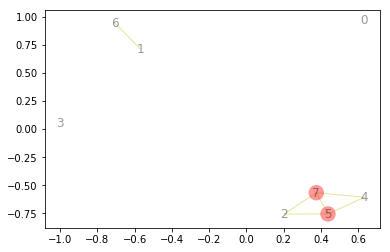

In [98]:
nx.draw_networkx(G, pos, node_size=node_size, edge_color='y', alpha=.4, linewidths=0)

### Dendogram

In [99]:
from scipy import spatial as scs
from scipy.cluster import hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from gensim.matutils import jensen_shannon

# get topic distributions
topic_dist = optimal_model.state.get_lambda()

# get topic terms
num_words = 300
topic_terms = [{w for (w, _) in optimal_model.show_topic(topic, topn=num_words)} for topic in range(topic_dist.shape[0])]

# no. of terms to display in annotation
n_ann_terms = 8

# use Jensen-Shannon distance metric in dendrogram
def js_dist(X):
    return pdist(X, lambda u, v: jensen_shannon(u, v))

# define method for distance calculation in clusters
linkagefun=lambda x: sch.linkage(x, 'single')

# calculate text annotations
def text_annotation(topic_dist, topic_terms, n_ann_terms, linkagefun):
    # get dendrogram hierarchy data
    linkagefun = lambda x: sch.linkage(x, 'single')
    d = js_dist(topic_dist)
    Z = linkagefun(d)
    P = sch.dendrogram(Z, orientation="bottom", no_plot=True)

    # store topic no.(leaves) corresponding to the x-ticks in dendrogram
    x_ticks = np.arange(5, len(P['leaves']) * 10 + 5, 10)
    x_topic = dict(zip(P['leaves'], x_ticks))

    # store {topic no.:topic terms}
    topic_vals = dict()
    for key, val in x_topic.items():
        topic_vals[val] = (topic_terms[key], topic_terms[key])

    text_annotations = []
    # loop through every trace (scatter plot) in dendrogram
    for trace in P['icoord']:
        fst_topic = topic_vals[trace[0]]
        scnd_topic = topic_vals[trace[2]]
        
        # annotation for two ends of current trace
        pos_tokens_t1 = list(fst_topic[0])[:min(len(fst_topic[0]), n_ann_terms)]
        neg_tokens_t1 = list(fst_topic[1])[:min(len(fst_topic[1]), n_ann_terms)]

        pos_tokens_t4 = list(scnd_topic[0])[:min(len(scnd_topic[0]), n_ann_terms)]
        neg_tokens_t4 = list(scnd_topic[1])[:min(len(scnd_topic[1]), n_ann_terms)]

        t1 = "<br>".join((": ".join(("+++", str(pos_tokens_t1))), ": ".join(("---", str(neg_tokens_t1)))))
        t2 = t3 = ()
        t4 = "<br>".join((": ".join(("+++", str(pos_tokens_t4))), ": ".join(("---", str(neg_tokens_t4)))))

        # show topic terms in leaves
        if trace[0] in x_ticks:
            t1 = str(list(topic_vals[trace[0]][0])[:n_ann_terms])
        if trace[2] in x_ticks:
            t4 = str(list(topic_vals[trace[2]][0])[:n_ann_terms])

        text_annotations.append([t1, t2, t3, t4])

        # calculate intersecting/diff for upper level
        intersecting = fst_topic[0] & scnd_topic[0]
        different = fst_topic[0].symmetric_difference(scnd_topic[0])

        center = (trace[0] + trace[2]) / 2
        topic_vals[center] = (intersecting, different)

        # remove trace value after it is annotated
        topic_vals.pop(trace[0], None)
        topic_vals.pop(trace[2], None)  
        
    return text_annotations

# get text annotations
annotation = text_annotation(topic_dist, topic_terms, n_ann_terms, linkagefun)

# Plot dendrogram
dendro = ff.create_dendrogram(topic_dist, distfun=js_dist, labels=range(0, 8), linkagefun=linkagefun, hovertext=annotation)
dendro['layout'].update({'width': 1000, 'height': 600})
py.iplot(dendro)

### t-SNE

Refactoring results of LDA into numpy matrix (number_of_patents x number_of_topics).

In [100]:
hm = np.array([[y for (x,y) in optimal_model[corpus_tfidf[i]]] for i in range(len(corpus_tfidf))])

In [101]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=2017, perplexity=30)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

In [104]:
year=patent['year']

In [105]:
source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = [all_palettes['Set1'][8][i] for i in embedding.hue],
            title = patent.appln_title,
            year = year,
            alpha = [0.9] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Papers')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.trigger('change');
""")

slider = Slider(start=year.min(), end=year.max(), value=2017, step=1, title="Before year")
slider.js_on_change('value', callback)

layout = column(slider, plot_tsne)

In [106]:
show(layout)

# Addiotinal Code

### Frequency Distribution of Word Counts in Documents

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 120, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 100,"Median  : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev  : " + str(round(np.std(doc_lens))))
plt.text(750,  60, "1%ile   : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  40, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 900), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,900,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 15):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

Colors are given from above shown plot. 

Blue for topic 0, orange for topic 1, green for topic 2 , and red for topic 3.

### The most discussed topics in the documents

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.<br>
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 15000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# Visualize topics


###  t-SNE Clustering Chart

t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

###  pyLDAVis

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis